In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, SVHN
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, Grayscale
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:1'

In [3]:
def weights_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        layer.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        layer.weight.data.normal_(1.0, 0.02)
        layer.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        size = layer.weight.size()
        layer.weight.data.normal_(0.0, 0.1)
        layer.bias.data.fill_(0)

In [4]:
seed = 0
width = 32
channels = 3
batch_size = 100
epochs = 10

filters = 64
embedding_dim = 128
lr = 0.0005
beta1 = 0.8

In [5]:
_ = torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
transform = Compose([Resize(width), Grayscale(channels), ToTensor(), Normalize([0.5]*channels, [0.5]*channels)])

In [7]:
source_train = SVHN(root='../datasets/', transform=transform, split='train')
source_validation = SVHN(root='../datasets/', transform=transform, split='test')
nclasses = len(set(source_train.labels))

In [8]:
# Encoder
F = nn.Sequential(
    nn.Conv2d(channels, filters, 5, 1, 0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(filters, filters, 5, 1, 0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(filters, embedding_dim, 5, 1,0),
    nn.ReLU(inplace=True)
).apply(weights_init).to(device)

In [9]:
# Classifier
C = nn.Sequential(
    nn.Linear(2*filters, 2*filters),
    nn.ReLU(inplace=True),
    nn.Linear(2*filters, nclasses),      
).apply(weights_init).to(device)

In [10]:
criterion_clf = nn.CrossEntropyLoss().to(device)

In [11]:
optimizerF = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerC = optim.Adam(C.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
source_train_loader = DataLoader(source_train, batch_size=batch_size, shuffle=True, drop_last=True)
source_validation_loader = DataLoader(source_validation, batch_size=batch_size, shuffle=True, drop_last=False)

In [13]:
losses = {
    'F': [],
    'C': []
}
accuracy = []

In [14]:
for _ in range(epochs):
    F.train()
    C.train()
    for it, source_batch in enumerate(source_train_loader):
        '''
        Pre-processing
        '''
        source_images, source_labels = map(lambda v: v.to(device), source_batch)   
        
        # compute one-hot vectors
        source_labels_oh = nn.functional.one_hot(source_labels, nclasses+1).float().to(device)
        
        # compute emeddings from source images
        source_embedding = F(source_images).view(batch_size, -1)
    
        '''
        Update C
        '''
        C.zero_grad()
        
        # compute classifier losses
        source_clf = C(source_embedding)
        C_loss = criterion_clf(source_clf, source_labels)
        
        # perform G optimization step
        C_loss.backward(retain_graph=True)
        optimizerC.step()
        
        '''
        Update F
        '''
        F.zero_grad()
        
        # compute encoder loss from updated classifier
        source_clf = C(source_embedding)
        C_loss = criterion_clf(source_clf, source_labels)
        F_loss = C_loss
        F_loss.backward(retain_graph=True)
        optimizerF.step()
        
        '''
        Bookkeeping
        '''
        losses['F'].append(F_loss.item())
        losses['C'].append(C_loss.item())
        
    F.eval()
    C.eval()
    
    correct, total = [], []
    for it, (images, labels) in enumerate(source_validation_loader):
        images, labels = images.to(device), labels.to(device)
        embeddings = F(images).squeeze()
        predictions = C(embeddings)
        correct.append(torch.sum(torch.argmax(predictions, 1) == labels).item())
        total.append(len(images))
    accuracy.append(sum(correct)/sum(total))

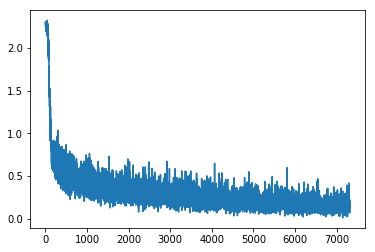

In [15]:
plt.plot(losses['C'])
plt.show()

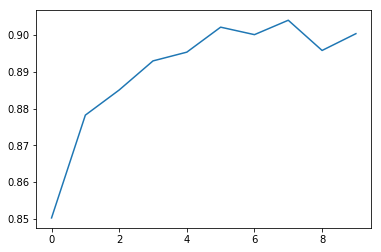

In [16]:
plt.plot(accuracy)
plt.show()